# Import Library

In [247]:
#!pip install torchmetrics

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import FitFailedWarning
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
#plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('always', FitFailedWarning)
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [249]:
df=pd. read_csv('81250_202302_BeltCurrent.csv', engine='python', encoding='utf-8', error_bad_lines=False)
df

,floatvalue,t_stamp
0,17.992546,1675209793867
1,18.385374,1675209813868
2,18.549816,1675209833869
3,18.448912,1675209853870
4,18.515699,1675209873872
...,...,...
60483,19.219530,1677628600856
60484,19.165195,1677628640859
60485,19.222761,1677628660861
60486,19.225843,1677628680863


In [250]:
df.index.freq="MS"
df['t_stamp']= pd.to_datetime(df['t_stamp'], unit='ms') ##, unit='ms'
#df=df.iloc[3535:9200]
df

,floatvalue,t_stamp
0,17.992546,2023-02-01 00:03:13.867
1,18.385374,2023-02-01 00:03:33.868
2,18.549816,2023-02-01 00:03:53.869
3,18.448912,2023-02-01 00:04:13.870
4,18.515699,2023-02-01 00:04:33.872
...,...,...
60483,19.219530,2023-02-28 23:56:40.856
60484,19.165195,2023-02-28 23:57:20.859
60485,19.222761,2023-02-28 23:57:40.861
60486,19.225843,2023-02-28 23:58:00.863


In [251]:
df = df.set_index('t_stamp')
df.index = pd.to_datetime(df.index)

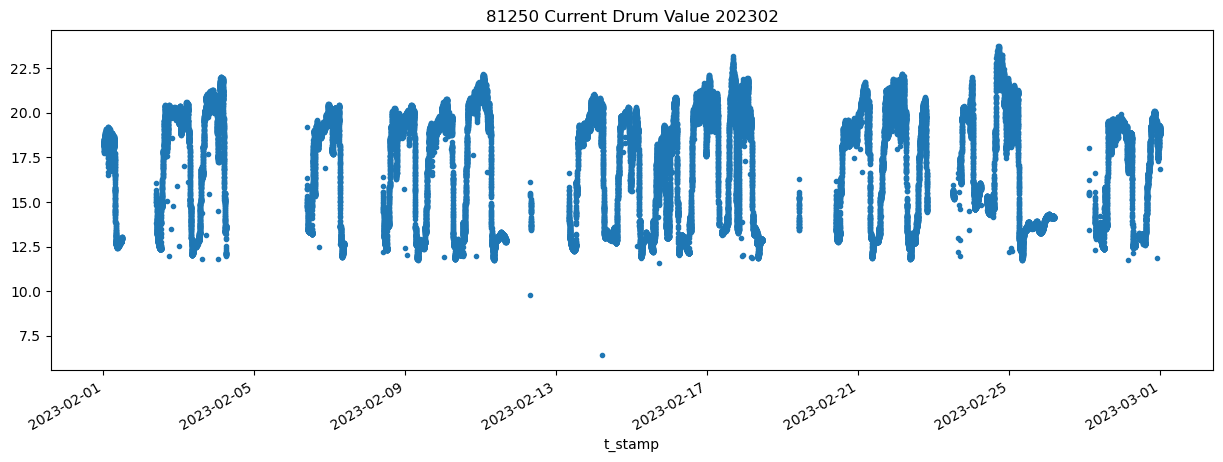

In [252]:
df['floatvalue'].plot(style='.',
        figsize=(15, 5),
       ## color=color_pal[0],
        title='81250 Current Drum Value 202302')
plt.show()

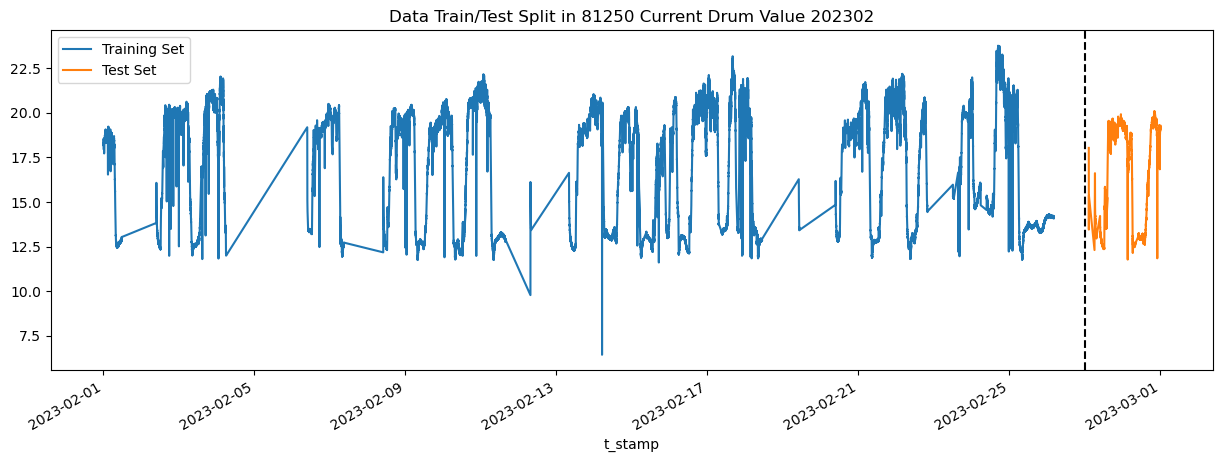

In [253]:
train = df.loc[df.index < '2023-02-27']
test = df.loc[df.index >= '2023-02-27']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split in 81250 Current Drum Value 202302')
test.plot(ax=ax, label='Test Set')
ax.axvline('2023-02-27', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

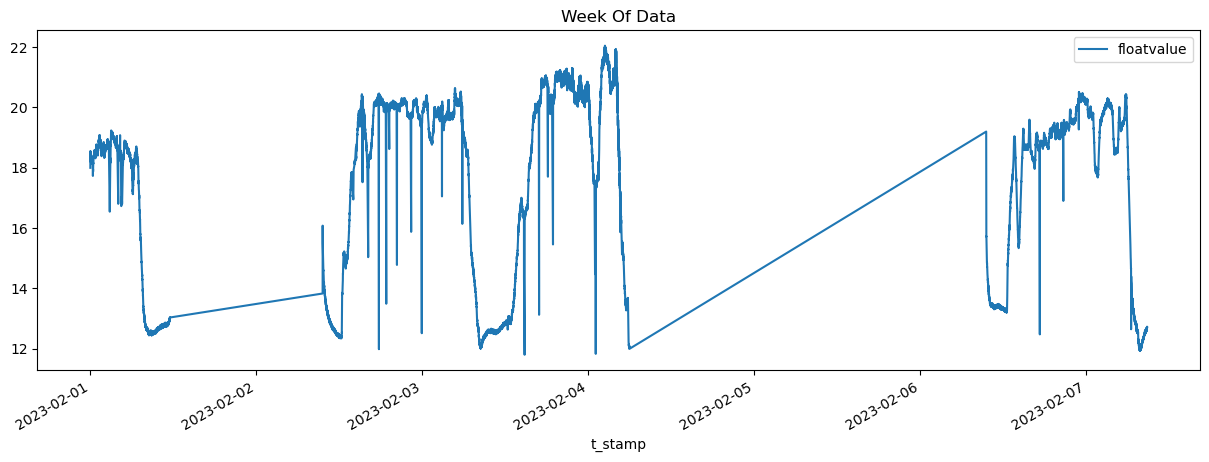

In [254]:
df.loc[(df.index > '2023-02-01') & (df.index < '2023-02-08')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature

In [255]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['min'] = df.index.minute
    
    return df

df = create_features(df)

# Visualiztion

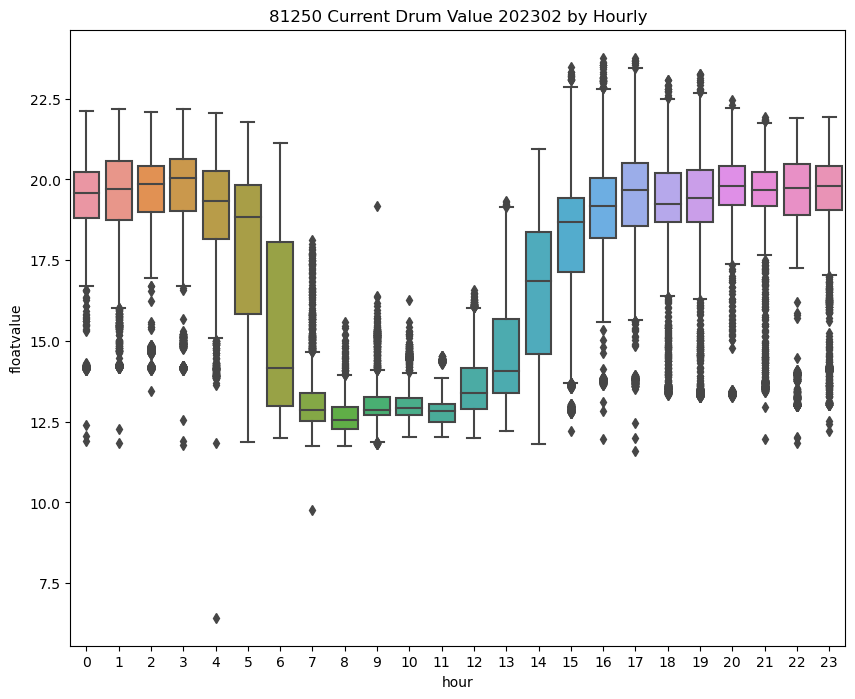

In [256]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='floatvalue')
ax.set_title('81250 Current Drum Value 202302 by Hourly')
plt.show()

<Axes: xlabel='hour', ylabel='floatvalue'>

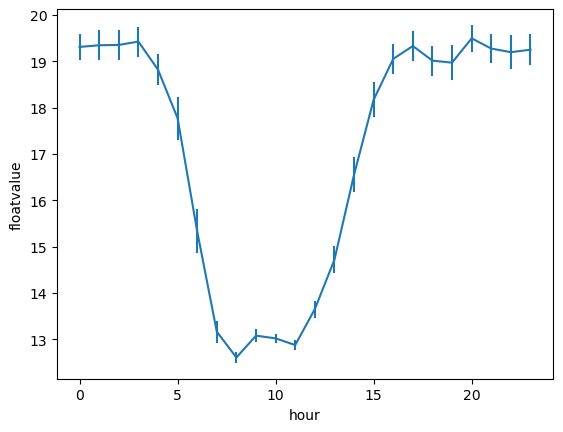

In [257]:
#sns.histplot(data=df,  x='hour', y='floatvalue', kde = True )
#sns.lineplot(data=df,  x='hour', y='floatvalue')
sns.lineplot(
   data=df,  x='hour', y='floatvalue', err_style="bars", errorbar=("se", 8),
)

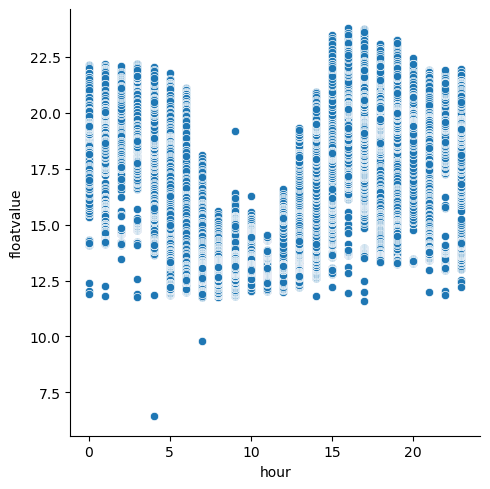

In [258]:
sns.relplot(
    data=df,
     x='hour', y='floatvalue'
)

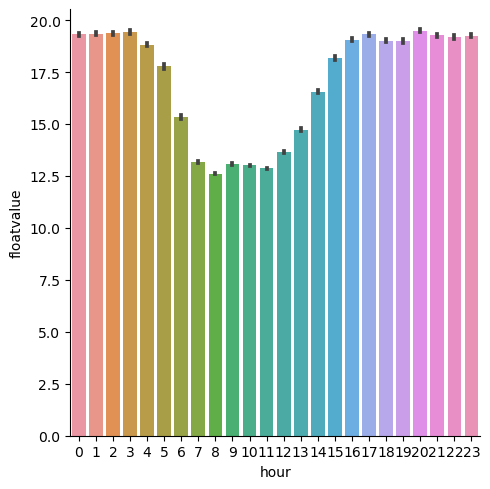

In [259]:
sns.catplot(data=df, kind="bar", x='hour', y='floatvalue')

# Model Created 

In [260]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'min']
TARGET = 'floatvalue'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [261]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=6,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[09:29:13] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:16.90983	validation_1-rmse:16.37732
[100]	validation_0-rmse:6.32471	validation_1-rmse:5.58484
[200]	validation_0-rmse:2.63157	validation_1-rmse:1.83777
[300]	validation_0-rmse:1.55671	validation_1-rmse:1.07168
[353]	validation_0-rmse:1.39323	validation_1-rmse:1.12636


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [262]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [263]:
score=reg.score(X_train, y_train)
print("Training Score: ", score)

Training Score:  0.770332767684042


In [264]:
score1=reg.score(X_test, y_test)
print("Training Score: ", score1)

Training Score:  0.8476577854069616


In [265]:
len(y_test)

4980

In [266]:
from sklearn.model_selection import cross_val_score, KFold

# Feature Importance

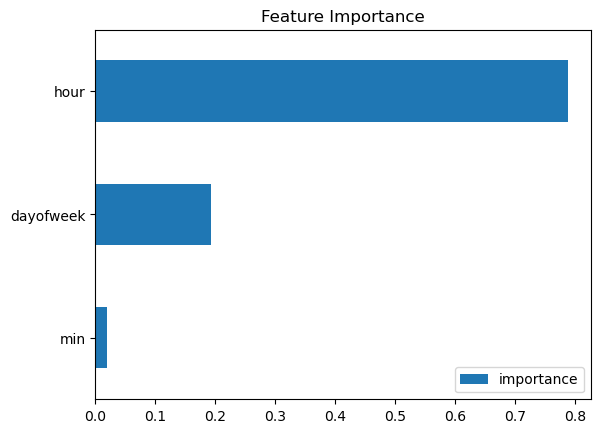

In [267]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast 

In [268]:
# test['prediction'] = reg.predict(X_test)
# df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
# ax = df[['floatvalue']].plot(figsize=(15, 5))
# df['prediction'].plot(ax=ax,style='.')

# plt.legend(['Actual Data', 'Predictions'])
# ax.set_title('Actual Data and Prediction')
# plt.show()

In [269]:
# test['prediction'] = reg.predict(X_test)
# df = df.loc[df.index >= '2023-02-27'].merge(test[['prediction']], how='left', left_index=True, right_index=True)
# ax = df[['floatvalue']].plot(figsize=(15, 5))
# #df['prediction'].plot(ax=ax,style='.')
# df['prediction'].plot(kind='line')
# plt.legend(['Actual Data', 'Predictions'])
# ax.set_title('Actual Data and Prediction')
# plt.show()

In [270]:
test

,floatvalue,hour,dayofweek,min
t_stamp,,,,
2023-02-27 02:27:09.290,18.036032,2,0,27
2023-02-27 02:29:09.296,16.240328,2,0,29
2023-02-27 02:29:29.297,13.452840,2,0,29
2023-02-27 02:29:49.298,15.523540,2,0,29
2023-02-27 02:30:09.300,15.588556,2,0,30
...,...,...,...,...
2023-02-28 23:56:40.856,19.219530,23,1,56
2023-02-28 23:57:20.859,19.165195,23,1,57
2023-02-28 23:57:40.861,19.222761,23,1,57


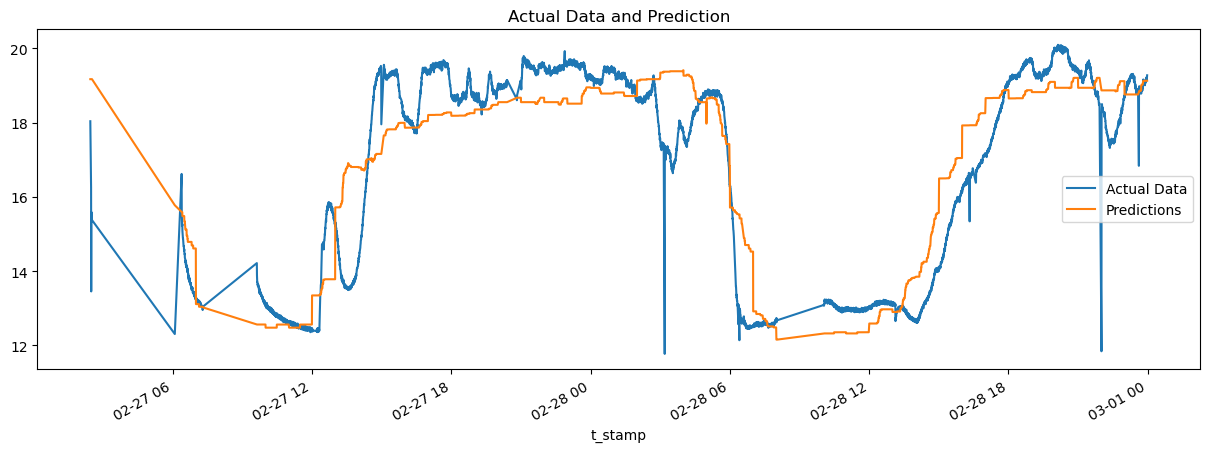

In [271]:
test['prediction'] = reg.predict(X_test)
df = df.loc[df.index >= '2023-02-27'].merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df[['floatvalue']].plot(figsize=(15, 5))
#df['prediction'].plot(ax=ax,style='.')
df['prediction'].plot(kind='line')
#df['per'].plot(kind='line')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Actual Data and Prediction')
plt.show()

In [272]:
test

,floatvalue,hour,dayofweek,min,prediction
t_stamp,,,,,
2023-02-27 02:27:09.290,18.036032,2,0,27,19.168917
2023-02-27 02:29:09.296,16.240328,2,0,29,19.168917
2023-02-27 02:29:29.297,13.452840,2,0,29,19.168917
2023-02-27 02:29:49.298,15.523540,2,0,29,19.168917
2023-02-27 02:30:09.300,15.588556,2,0,30,19.168917
...,...,...,...,...,...
2023-02-28 23:56:40.856,19.219530,23,1,56,19.126205
2023-02-28 23:57:20.859,19.165195,23,1,57,19.126205
2023-02-28 23:57:40.861,19.222761,23,1,57,19.126205


In [273]:
check =[(test['prediction']>y_test)]
per=['yes']
test['per']=np.select(check,per,default='no')
test

,floatvalue,hour,dayofweek,min,prediction,per
t_stamp,,,,,,
2023-02-27 02:27:09.290,18.036032,2,0,27,19.168917,yes
2023-02-27 02:29:09.296,16.240328,2,0,29,19.168917,yes
2023-02-27 02:29:29.297,13.452840,2,0,29,19.168917,yes
2023-02-27 02:29:49.298,15.523540,2,0,29,19.168917,yes
2023-02-27 02:30:09.300,15.588556,2,0,30,19.168917,yes
...,...,...,...,...,...,...
2023-02-28 23:56:40.856,19.219530,23,1,56,19.126205,no
2023-02-28 23:57:20.859,19.165195,23,1,57,19.126205,no
2023-02-28 23:57:40.861,19.222761,23,1,57,19.126205,no


In [274]:
test[['prediction','floatvalue','per']]

,prediction,floatvalue,per
t_stamp,,,
2023-02-27 02:27:09.290,19.168917,18.036032,yes
2023-02-27 02:29:09.296,19.168917,16.240328,yes
2023-02-27 02:29:29.297,19.168917,13.452840,yes
2023-02-27 02:29:49.298,19.168917,15.523540,yes
2023-02-27 02:30:09.300,19.168917,15.588556,yes
...,...,...,...
2023-02-28 23:56:40.856,19.126205,19.219530,no
2023-02-28 23:57:20.859,19.126205,19.165195,no
2023-02-28 23:57:40.861,19.126205,19.222761,no


In [275]:
test.drop(columns=['hour', 'dayofweek','min'])

,floatvalue,prediction,per
t_stamp,,,
2023-02-27 02:27:09.290,18.036032,19.168917,yes
2023-02-27 02:29:09.296,16.240328,19.168917,yes
2023-02-27 02:29:29.297,13.452840,19.168917,yes
2023-02-27 02:29:49.298,15.523540,19.168917,yes
2023-02-27 02:30:09.300,15.588556,19.168917,yes
...,...,...,...
2023-02-28 23:56:40.856,19.219530,19.126205,no
2023-02-28 23:57:20.859,19.165195,19.126205,no
2023-02-28 23:57:40.861,19.222761,19.126205,no


In [276]:
df

,floatvalue,hour,dayofweek,min,prediction
t_stamp,,,,,
2023-02-27 02:27:09.290,18.036032,2,0,27,19.168917
2023-02-27 02:29:09.296,16.240328,2,0,29,19.168917
2023-02-27 02:29:29.297,13.452840,2,0,29,19.168917
2023-02-27 02:29:49.298,15.523540,2,0,29,19.168917
2023-02-27 02:30:09.300,15.588556,2,0,30,19.168917
...,...,...,...,...,...
2023-02-28 23:56:40.856,19.219530,23,1,56,19.126205
2023-02-28 23:57:20.859,19.165195,23,1,57,19.126205
2023-02-28 23:57:40.861,19.222761,23,1,57,19.126205


In [277]:
test.to_csv('20230411_0250.csv', index = None, header=True)

In [278]:
forecast_data_true=test[test['per']=="yes"]
forecast_data_true=pd.DataFrame(forecast_data_true,columns=['ds','yhat','outers'])

forecast_data_false=test[test['per']=="no"]
forecast_data_false=pd.DataFrame(forecast_data_false,columns=['ds','yhat','outers'])

In [279]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-02-27    0.912504
2023-02-28    0.767125
Name: error, dtype: float64

In [280]:
import torch
import torchmetrics
from torchmetrics import Accuracy

In [281]:
test['prediction']

t_stamp
2023-02-27 02:27:09.290    19.168917
2023-02-27 02:29:09.296    19.168917
2023-02-27 02:29:29.297    19.168917
2023-02-27 02:29:49.298    19.168917
2023-02-27 02:30:09.300    19.168917
                             ...    
2023-02-28 23:56:40.856    19.126205
2023-02-28 23:57:20.859    19.126205
2023-02-28 23:57:40.861    19.126205
2023-02-28 23:58:00.863    19.126205
2023-02-28 23:58:20.864    19.126205
Name: prediction, Length: 4980, dtype: float32

In [282]:
y_test

t_stamp
2023-02-27 02:27:09.290    18.036032
2023-02-27 02:29:09.296    16.240328
2023-02-27 02:29:29.297    13.452840
2023-02-27 02:29:49.298    15.523540
2023-02-27 02:30:09.300    15.588556
                             ...    
2023-02-28 23:56:40.856    19.219530
2023-02-28 23:57:20.859    19.165195
2023-02-28 23:57:40.861    19.222761
2023-02-28 23:58:00.863    19.225843
2023-02-28 23:58:20.864    19.273302
Name: floatvalue, Length: 4980, dtype: float64

In [283]:
test['prediction']

t_stamp
2023-02-27 02:27:09.290    19.168917
2023-02-27 02:29:09.296    19.168917
2023-02-27 02:29:29.297    19.168917
2023-02-27 02:29:49.298    19.168917
2023-02-27 02:30:09.300    19.168917
                             ...    
2023-02-28 23:56:40.856    19.126205
2023-02-28 23:57:20.859    19.126205
2023-02-28 23:57:40.861    19.126205
2023-02-28 23:58:00.863    19.126205
2023-02-28 23:58:20.864    19.126205
Name: prediction, Length: 4980, dtype: float32

In [284]:
check =[(test['prediction']>y_test)]
per=['yes']
test['per']=np.select(check,per,default='no')
test

,floatvalue,hour,dayofweek,min,prediction,per,error,date
t_stamp,,,,,,,,
2023-02-27 02:27:09.290,18.036032,2,0,27,19.168917,yes,1.132885,2023-02-27
2023-02-27 02:29:09.296,16.240328,2,0,29,19.168917,yes,2.928589,2023-02-27
2023-02-27 02:29:29.297,13.452840,2,0,29,19.168917,yes,5.716077,2023-02-27
2023-02-27 02:29:49.298,15.523540,2,0,29,19.168917,yes,3.645376,2023-02-27
2023-02-27 02:30:09.300,15.588556,2,0,30,19.168917,yes,3.580360,2023-02-27
...,...,...,...,...,...,...,...,...
2023-02-28 23:56:40.856,19.219530,23,1,56,19.126205,no,0.093325,2023-02-28
2023-02-28 23:57:20.859,19.165195,23,1,57,19.126205,no,0.038990,2023-02-28
2023-02-28 23:57:40.861,19.222761,23,1,57,19.126205,no,0.096556,2023-02-28


In [285]:
test[['prediction','floatvalue','per']]

,prediction,floatvalue,per
t_stamp,,,
2023-02-27 02:27:09.290,19.168917,18.036032,yes
2023-02-27 02:29:09.296,19.168917,16.240328,yes
2023-02-27 02:29:29.297,19.168917,13.452840,yes
2023-02-27 02:29:49.298,19.168917,15.523540,yes
2023-02-27 02:30:09.300,19.168917,15.588556,yes
...,...,...,...
2023-02-28 23:56:40.856,19.126205,19.219530,no
2023-02-28 23:57:20.859,19.126205,19.165195,no
2023-02-28 23:57:40.861,19.126205,19.222761,no


In [286]:
forecast_data_true=test[test['per']=="yes"]
forecast_data_true=pd.DataFrame(forecast_data_true,columns=['prediction','per','floatvalue'])

forecast_data_false=test[test['per']=="no"]
forecast_data_false=pd.DataFrame(forecast_data_false,columns=['prediction','per','floatvalue'])

In [287]:
import plotly.graph_objects as go
df = px.data.iris()

In [288]:
test

,floatvalue,hour,dayofweek,min,prediction,per,error,date
t_stamp,,,,,,,,
2023-02-27 02:27:09.290,18.036032,2,0,27,19.168917,yes,1.132885,2023-02-27
2023-02-27 02:29:09.296,16.240328,2,0,29,19.168917,yes,2.928589,2023-02-27
2023-02-27 02:29:29.297,13.452840,2,0,29,19.168917,yes,5.716077,2023-02-27
2023-02-27 02:29:49.298,15.523540,2,0,29,19.168917,yes,3.645376,2023-02-27
2023-02-27 02:30:09.300,15.588556,2,0,30,19.168917,yes,3.580360,2023-02-27
...,...,...,...,...,...,...,...,...
2023-02-28 23:56:40.856,19.219530,23,1,56,19.126205,no,0.093325,2023-02-28
2023-02-28 23:57:20.859,19.165195,23,1,57,19.126205,no,0.038990,2023-02-28
2023-02-28 23:57:40.861,19.222761,23,1,57,19.126205,no,0.096556,2023-02-28


In [289]:
test['upper_limit']=test.floatvalue+0.15*(test.floatvalue)
test['upper_limit']

t_stamp
2023-02-27 02:27:09.290    20.741436
2023-02-27 02:29:09.296    18.676377
2023-02-27 02:29:29.297    15.470766
2023-02-27 02:29:49.298    17.852072
2023-02-27 02:30:09.300    17.926840
                             ...    
2023-02-28 23:56:40.856    22.102460
2023-02-28 23:57:20.859    22.039975
2023-02-28 23:57:40.861    22.106175
2023-02-28 23:58:00.863    22.109720
2023-02-28 23:58:20.864    22.164297
Name: upper_limit, Length: 4980, dtype: float64

In [290]:
test['lower_limit']=test.floatvalue-0.15*(test.floatvalue)
test['lower_limit']

t_stamp
2023-02-27 02:27:09.290    15.330627
2023-02-27 02:29:09.296    13.804279
2023-02-27 02:29:29.297    11.434914
2023-02-27 02:29:49.298    13.195009
2023-02-27 02:30:09.300    13.250273
                             ...    
2023-02-28 23:56:40.856    16.336601
2023-02-28 23:57:20.859    16.290416
2023-02-28 23:57:40.861    16.339347
2023-02-28 23:58:00.863    16.341967
2023-02-28 23:58:20.864    16.382307
Name: lower_limit, Length: 4980, dtype: float64

In [306]:
check =[(test['prediction']>upper_limit) |(test['prediction']<lower_limit)]
per=['yes']
test['per']=np.select(check,per,default='no')
test

,floatvalue,hour,dayofweek,min,prediction,per,error,date,upper_limit,lower_limit
t_stamp,,,,,,,,,,
2023-02-27 02:27:09.290,18.036032,2,0,27,19.168917,no,1.132885,2023-02-27,20.741436,15.330627
2023-02-27 02:29:09.296,16.240328,2,0,29,19.168917,yes,2.928589,2023-02-27,18.676377,13.804279
2023-02-27 02:29:29.297,13.452840,2,0,29,19.168917,yes,5.716077,2023-02-27,15.470766,11.434914
2023-02-27 02:29:49.298,15.523540,2,0,29,19.168917,yes,3.645376,2023-02-27,17.852072,13.195009
2023-02-27 02:30:09.300,15.588556,2,0,30,19.168917,yes,3.580360,2023-02-27,17.926840,13.250273
...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:56:40.856,19.219530,23,1,56,19.126205,no,0.093325,2023-02-28,22.102460,16.336601
2023-02-28 23:57:20.859,19.165195,23,1,57,19.126205,no,0.038990,2023-02-28,22.039975,16.290416
2023-02-28 23:57:40.861,19.222761,23,1,57,19.126205,no,0.096556,2023-02-28,22.106175,16.339347


In [307]:
forecast_data_true=test[test['per']=="yes"]
forecast_data_true=pd.DataFrame(forecast_data_true,columns=['prediction','per','floatvalue'])

forecast_data_false=test[test['per']=="no"]
forecast_data_false=pd.DataFrame(forecast_data_false,columns=['prediction','per','floatvalue'])

In [308]:
fig6=px.scatter(forecast_data_true.reset_index(), x='t_stamp', y='prediction',color_discrete_sequence=['red'])
fig2=px.line(test.reset_index(), x='t_stamp', y='prediction',color_discrete_sequence=['mediumpurple'])
#fig1=px.line(test.reset_index(), x='t_stamp', y='floatvalue',color_discrete_sequence=['salmon'])
#fig2 = px.line(test.reset_index(), x='ds', y='yhat',labels={"yhat": "Predict Data"},color_discrete_sequence=['salmon'])
figtotal = go.Figure(data=  fig6.data + fig2.data)
figtotal.update_layout(yaxis_range=[0,25], title_text='202302 Current Belt 81250 Predict Future Value',title_x=0.5)
figtotal.update_yaxes(title_text="Float Values",tickfont_family="Arial Black")
figtotal.show()

In [322]:
fig1=px.scatter(forecast_data_true.reset_index(), x='t_stamp', y='prediction',color_discrete_sequence=['red'])
fig3=px.line(test.reset_index(), x='t_stamp', y='prediction',color_discrete_sequence=['mediumpurple'])
fig2=px.line(test.reset_index(), x='t_stamp', y='lower_limit',color_discrete_sequence=['lightcoral'])
fig4=px.line(test.reset_index(), x='t_stamp', y='upper_limit',color_discrete_sequence=['skyblue'])
#fig5=px.line(test.reset_index(), x='t_stamp', y='floatvalue',color_discrete_sequence=['pink'])
#fig2 = px.line(test.reset_index(), x='ds', y='yhat',labels={"yhat": "Predict Data"},color_discrete_sequence=['salmon'])
#figtotal = go.Figure(data= fig1.data +fig3.data +fig2.data+fig4.data)
figtotal = go.Figure(data=fig3.data +fig1.data+fig2.data+fig4.data)
figtotal.update_layout(yaxis_range=[0,25], title_text='202302 Current Belt 81250 Predict Future Value',title_x=0.5)
figtotal.update_yaxes(title_text="Float Values",tickfont_family="Arial Black")
figtotal.show()

# Alert Messages

In [323]:
test

,floatvalue,hour,dayofweek,min,prediction,per,error,date,upper_limit,lower_limit
t_stamp,,,,,,,,,,
2023-02-27 02:27:09.290,18.036032,2,0,27,19.168917,no,1.132885,2023-02-27,20.741436,15.330627
2023-02-27 02:29:09.296,16.240328,2,0,29,19.168917,yes,2.928589,2023-02-27,18.676377,13.804279
2023-02-27 02:29:29.297,13.452840,2,0,29,19.168917,yes,5.716077,2023-02-27,15.470766,11.434914
2023-02-27 02:29:49.298,15.523540,2,0,29,19.168917,yes,3.645376,2023-02-27,17.852072,13.195009
2023-02-27 02:30:09.300,15.588556,2,0,30,19.168917,yes,3.580360,2023-02-27,17.926840,13.250273
...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:56:40.856,19.219530,23,1,56,19.126205,no,0.093325,2023-02-28,22.102460,16.336601
2023-02-28 23:57:20.859,19.165195,23,1,57,19.126205,no,0.038990,2023-02-28,22.039975,16.290416
2023-02-28 23:57:40.861,19.222761,23,1,57,19.126205,no,0.096556,2023-02-28,22.106175,16.339347


In [329]:
test.query('per=="yes"')

,floatvalue,hour,dayofweek,min,prediction,per,error,date,upper_limit,lower_limit
t_stamp,,,,,,,,,,
2023-02-27 02:29:09.296,16.240328,2,0,29,19.168917,yes,2.928589,2023-02-27,18.676377,13.804279
2023-02-27 02:29:29.297,13.452840,2,0,29,19.168917,yes,5.716077,2023-02-27,15.470766,11.434914
2023-02-27 02:29:49.298,15.523540,2,0,29,19.168917,yes,3.645376,2023-02-27,17.852072,13.195009
2023-02-27 02:30:09.300,15.588556,2,0,30,19.168917,yes,3.580360,2023-02-27,17.926840,13.250273
2023-02-27 02:30:29.302,15.439016,2,0,30,19.168917,yes,3.729900,2023-02-27,17.754869,13.123164
...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:08:38.623,14.259707,15,1,8,16.495546,yes,2.235839,2023-02-28,16.398664,12.120751
2023-02-28 15:09:38.626,14.322931,15,1,9,16.495546,yes,2.172615,2023-02-28,16.471371,12.174492
2023-02-28 15:10:18.629,14.323898,15,1,10,16.495546,yes,2.171648,2023-02-28,16.472483,12.175314


In [330]:
test.query('per=="no"')

,floatvalue,hour,dayofweek,min,prediction,per,error,date,upper_limit,lower_limit
t_stamp,,,,,,,,,,
2023-02-27 02:27:09.290,18.036032,2,0,27,19.168917,no,1.132885,2023-02-27,20.741436,15.330627
2023-02-27 06:23:10.242,16.617073,6,0,23,15.589548,no,1.027525,2023-02-27,19.109634,14.124512
2023-02-27 06:23:30.243,15.567449,6,0,23,15.589548,no,0.022099,2023-02-27,17.902566,13.232331
2023-02-27 06:24:30.246,15.216025,6,0,24,15.589548,no,0.373523,2023-02-27,17.498429,12.933622
2023-02-27 06:24:50.248,15.267520,6,0,24,15.589548,no,0.322028,2023-02-27,17.557648,12.977392
...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:56:40.856,19.219530,23,1,56,19.126205,no,0.093325,2023-02-28,22.102460,16.336601
2023-02-28 23:57:20.859,19.165195,23,1,57,19.126205,no,0.038990,2023-02-28,22.039975,16.290416
2023-02-28 23:57:40.861,19.222761,23,1,57,19.126205,no,0.096556,2023-02-28,22.106175,16.339347
